In [59]:
import pandas as pd

resultsList = pd.read_csv("./data2/results-list.csv")
resultsList = resultsList.where((pd.notnull(resultsList)), None)
serie = []
for i in resultsList['results']:
    serie.append(i.split("-")[2].split(".")[0])

serie = pd.Series(serie)

resultsList['type'] = serie
accuracy = []
mse = []
for i in resultsList['results']:
    dfTemp = pd.read_csv(i)
    dfMean = dfTemp.groupby(['sr']).mean().drop(['t'],axis=1)
    dfMean['accuracy']= (dfMean['TP']+dfMean['TN']) / (dfMean['TP']+dfMean['TN']+dfMean['FN']+dfMean['FP'])
    accuracy.append(dfMean['accuracy'].mean())
resultsList['accuracy'] = pd.Series(accuracy)

idx = resultsList.groupby(["file","type"])["accuracy"].transform(max) == resultsList['accuracy']

resultsList[(resultsList["type"] == "regression") & (resultsList["file"] == "Apache")].sort_values(["accuracy"])

,class_weight,criterion,file,max_depth,max_features,max_leaf_nodes,min_impurity_decrease,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,presort,random_state,results,splitter,type,accuracy
191,None,mse,Apache,10,None,70,1e-07,10,2,0,False,None,./data2/Apache-0096-regression.csv,best,regression,0.851374
23,None,mse,Apache,None,None,20,1e-07,10,2,0,False,None,./data2/Apache-0012-regression.csv,best,regression,0.851520
659,None,mse,Apache,60,None,10,1e-07,10,2,0,False,None,./data2/Apache-0330-regression.csv,best,regression,0.852105
1019,None,mse,Apache,90,None,40,1e-07,10,2,0,False,None,./data2/Apache-0510-regression.csv,best,regression,0.852164
431,None,mse,Apache,30,None,90,1e-07,10,2,0,False,None,./data2/Apache-0216-regression.csv,best,regression,0.852310
695,None,mse,Apache,60,None,40,1e-07,10,2,0,False,None,./data2/Apache-0348-regression.csv,best,regression,0.852339
83,None,mse,Apache,None,None,70,1e-07,10,2,0,False,None,./data2/Apache-0042-regression.csv,best,regression,0.852456
719,None,mse,Apache,60,None,60,1e-07,10,2,0,False,None,./data2/Apache-0360-regression.csv,best,regression,0.852544
251,None,mse,Apache,20,None,30,1e-07,10,2,0,False,None,./data2/Apache-0126-regression.csv,best,regression,0.852602
323,None,mse,Apache,20,None,90,1e-07,10,2,0,False,None,./data2/Apache-0162-regression.csv,best,regression,0.852602


In [60]:
resultsList[(resultsList["type"] == "regression") & (resultsList["file"] == "Apache")].sort_values(["accuracy"], ascending=False)[:1]

,class_weight,criterion,file,max_depth,max_features,max_leaf_nodes,min_impurity_decrease,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,presort,random_state,results,splitter,type,accuracy
11617,None,mae,Apache,70,None,60,1e-07,1,2,0,False,None,./data2/Apache-1489-regression.csv,best,regression,0.89693


In [61]:
r = resultsList[(resultsList["type"] == "regression") & (resultsList["file"] == "Apache")].sort_values(["accuracy"], ascending=False)[:1]
configuration = {}
for i in r.keys():
    if not i in ["results","type","accuracy","file"]:
        configuration[i] = r.iloc[0][i]
print(configuration)

{'class_weight': None, 'criterion': 'mae', 'max_depth': 70.0, 'max_features': None, 'max_leaf_nodes': 60, 'min_impurity_decrease': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': None, 'splitter': 'best'}


In [65]:
import numpy as np
from sklearn import tree
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

In [17]:
perf="perf"

d = pd.read_csv("../datasets/Apache.csv") # Open dataset
d = d.sort_values(by=perf) # Sort it by perf to get threshold values
d

,Base,HostnameLookups,KeepAlive,EnableSendfile,FollowSymLinks,AccessLog,ExtendedStatus,InMemory,Handle,perf
150,1,1,0,0,1,1,1,0,0,840
124,1,1,0,0,0,1,1,0,0,840
102,1,1,0,1,1,1,1,0,1,870
72,1,1,0,0,0,1,1,0,1,870
90,1,1,0,1,0,1,1,0,1,870
103,1,1,1,1,1,1,1,0,1,870
133,1,1,0,1,0,1,1,0,0,900
151,1,1,0,1,1,1,1,0,0,900
123,1,1,0,0,0,1,0,0,0,900
145,1,1,0,0,1,1,0,0,0,900


In [18]:
d[perf].mean()

1427.65625

In [88]:
sr = 0.1
NSUBS = 10
t = d[perf].mean()

shuffle_split = StratifiedShuffleSplit(train_size=sr, n_splits=NSUBS)

d["label"] = 0
d.loc[d[perf] > t, "label"] = 1

/usr/lib64/python3.6/site-packages/sklearn/model_selection/_split.py:1639: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [89]:
#del(configuration['class_weight'])
c = tree.DecisionTreeRegressor(**configuration)

ndfTotal = pd.DataFrame()

for train_index, test_index in shuffle_split.split(d,d.label):
    d[perf].iloc[train_index]
    c.fit(d.drop([perf,"label"],axis=1).iloc[train_index], d[perf].iloc[train_index])
    pred = c.predict(d.drop([perf,"label"],axis=1).iloc[test_index])
    
    ndf = pd.DataFrame()
    ndf['perf'] = d[perf].iloc[test_index]
    ndf['pred'] = pred
    ndf['error'] = ndf['perf'] - ndf['pred']
    ndf['square_error'] = ndf['error'] * ndf['error']
    ndf['label'] = d["label"].iloc[test_index]
    ndf["label_pred"] = 0
    ndf.loc[ndf["pred"] > t, "label_pred"] = 1
    ndf["label_well"] = ndf['label']==ndf['label_pred']
    
    ndfTotal = pd.concat([ndfTotal,ndf])

In [90]:
'''ndf = pd.DataFrame()
ndf['perf'] = d[perf].iloc[test_index]
ndf['pred'] = pred
ndf['error'] = ndf['perf'] - ndf['pred']
ndf['square_error'] = ndf['error'] * ndf['error']
ndf['label'] = d["label"].iloc[test_index]
ndf["label_pred"] = 0
ndf.loc[ndf["pred"] > t, "label_pred"] = 1
ndf["label_well"] = ndf['label']==ndf['label_pred']'''
ndf

,perf,pred,error,square_error,label,label_pred,label_well
107,1170,1200.0,-30.0,900.0,0,0,True
92,1080,1020.0,60.0,3600.0,0,0,True
174,1020,960.0,60.0,3600.0,0,0,True
159,1770,1980.0,-210.0,44100.0,1,1,True
2,2310,2190.0,120.0,14400.0,1,1,True
175,2160,1680.0,480.0,230400.0,1,1,True
137,1080,1080.0,0.0,0.0,0,0,True
34,1140,1200.0,-60.0,3600.0,0,0,True
70,960,960.0,0.0,0.0,0,0,True
54,1260,1350.0,-90.0,8100.0,0,0,True


In [91]:
ndfTotal[ndfTotal['label_well']==False]

,perf,pred,error,square_error,label,label_pred,label_well
94,1470,1260.0,210.0,44100.0,1,0,False
64,1350,1770.0,-420.0,176400.0,0,1,False
65,1200,1770.0,-570.0,324900.0,0,1,False
79,1020,2010.0,-990.0,980100.0,0,1,False
31,2070,870.0,1200.0,1440000.0,1,0,False
56,1950,1230.0,720.0,518400.0,1,0,False
83,1080,1620.0,-540.0,291600.0,0,1,False
113,2040,1200.0,840.0,705600.0,1,0,False
97,1050,1470.0,-420.0,176400.0,0,1,False
103,870,1470.0,-600.0,360000.0,0,1,False


In [92]:
len(ndfTotal[ndfTotal['label_well']==True].index)

179

In [93]:
len(ndfTotal[ndfTotal['label_well']==False].index)

21

/usr/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


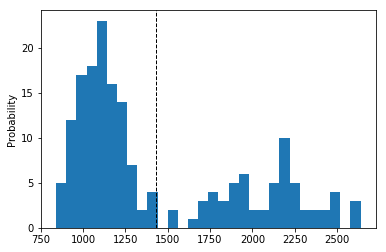

In [100]:
import matplotlib.pyplot as plt
import numpy as np
#%matplotlib inline
x = ndfTotal[ndfTotal['label_well']==True][perf]
plt.hist(x, normed=False, bins=30)
plt.axvline(t, color='k', linestyle='dashed', linewidth=1)
plt.ylabel('Probability');

/usr/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


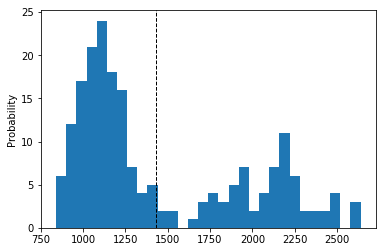

In [102]:
x = ndfTotal[perf]
plt.hist(x, normed=False, bins=30)
plt.axvline(t, color='k', linestyle='dashed', linewidth=1)
plt.ylabel('Probability');